In [1]:
from google.cloud import bigquery # modulo para interactuar con la API y el service account del DW
import pandas as pd
import numpy as np
from plotnine import *
%matplotlib inline
# un bonita funcion para hacer los querys 
def query_BQ(query_string):
    client = bigquery.Client() # inicializamos el cliente, pero antes se debe de fijar la variable de entorno 
    query_job = client.query(query_string)
    results = query_job.result().to_dataframe()  # Waits for job to complete and cast to pandas dataframe
    return(results)

In [4]:
from sklearn.preprocessing import scale
from h2o.automl import H2OAutoML
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ONaiveBayesEstimator
from sklearn.metrics import confusion_matrix
from google.cloud import bigquery # modulo para interactuar con la API y el service account del DW
import pandas as pd
import numpy as np
import h2o
import datetime
inicio = datetime.datetime.now()

In [3]:
query = '''
SELECT distinct user_id,
max(baby_age) as baby_age,
#max(days_to_convert) as days_to_convert, /*Use only for analysis*/
max(days_to_take_FT) as days_to_take_FT,
max(days_in_app) as days_in_app,
max(device) as device,#
max(adjust_network) as adjust_network,
max(android_app_version) as android_app_version,
max(android_lib_version) as android_lib_version /*.002 null class*/,
max(screen_width) as screenwidth,
max(timezone) as timezone,
max(user_relationship) as user_relationship,
max(user_role) as user_role,
#max(initial_assessment_completed) as initial_assessment_completed,
#max(FT_start) as FT_start,
#max(FT_conversion) as FT_conversion,
#mp_country,
y,
sum(case when video = "Completed" then 1 else 0 end) as Video_Completed,
sum(case when name ="OpenApp" then 1 else 0 end) as OpenApp,
sum(case when name ="S_DAPNewSkills" then 1 else 0 end) as S_DAPNewSkills,
sum(case when name ="AB_TEST" then 1 else 0 end) as AB_TEST,
sum(case when name ="S_SPHome" then 1 else 0 end) as S_SPHome,
sum(case when name ="S_SPLogin" then 1 else 0 end) as S_SPLogin,
sum(case when name ="LogIn" then 1 else 0 end) as LogIn,
sum(case when name ="SPForgotPass" then 1 else 0 end) as SPForgotPass,
sum(case when name ="S_SPSignup" then 1 else 0 end) as S_SPSignup,
sum(case when name ="SignUp" then 1 else 0 end) as SignUp,
sum(case when name ="OBCreateUser" then 1 else 0 end) as OBCreateUser,
sum(case when name ="S_OBBabyName" then 1 else 0 end) as S_OBBabyName,
sum(case when name ="OBCreateTwins" then 1 else 0 end) as OBCreateTwins,
sum(case when name ="S_OBPremature" then 1 else 0 end) as S_OBPremature,
sum(case when name ="Paywall_Dismiss" then 1 else 0 end) as Paywall_Dismiss,
sum(case when name ="S_InviteReceived" then 1 else 0 end) as S_InviteReceived,
sum(case when name ="InviteReceived" then 1 else 0 end) as InviteReceived,
sum(case when name ="S_Paywall_Soft" then 1 else 0 end) as S_Paywall_Soft,
sum(case when name ="S_IAIntro" then 1 else 0 end) as S_IAIntro,
sum(case when name ="IAStraightToActivities" then 1 else 0 end) as IAStraightToActivities,
sum(case when name ="IAStartAssessment" then 1 else 0 end) as IAStartAssessment,
sum(case when name ="IASkipAssessment" then 1 else 0 end) as IASkipAssessment,
sum(case when name ="MasterSkill" then 1 else 0 end) as MasterSkill,
sum(case when name ="IAFinishSkill" then 1 else 0 end) as IAFinishSkill,
sum(case when name ="S_HealthInterest" then 1 else 0 end) as S_HealthInterest,
sum(case when name ="S_IASetReminder" then 1 else 0 end) as S_IASetReminder,
sum(case when name ="IAReminder" then 1 else 0 end) as IAReminder,
sum(case when name ="S_IA_Answer_Skill" then 1 else 0 end) as S_IA_Answer_Skill,
sum(case when name ="DAPChangeActivity" then 1 else 0 end) as DAPChangeActivity,
sum(case when name ="S_DAPPastPlansPremium" then 1 else 0 end) as S_DAPPastPlansPremium,
sum(case when name ="DAPActivityCompleted" then 1 else 0 end) as DAPActivityCompleted,
sum(case when name ="S_DAPMaterials" then 1 else 0 end) as S_DAPMaterials,
sum(case when name ="MilestonesUpdate" then 1 else 0 end) as MilestonesUpdate,
sum(case when name ="ArticleView" then 1 else 0 end) as ArticleView,
sum(case when name ="SlideshowView" then 1 else 0 end) as SlideshowView,
sum(case when name ="ActivityView" then 1 else 0 end) as ActivityView,
sum(case when name ="ClickInDAP" then 1 else 0 end) as ClickInDAP,
sum(case when name ="RateActivityDAP" then 1 else 0 end) as RateActivityDAP,
sum(case when name ="Feedback_RateActivity" then 1 else 0 end) as Feedback_RateActivity,
sum(case when name ="Dismiss_Feedback_RateActivity" then 1 else 0 end) as Dismiss_Feedback_RateActivity,
sum(case when name ="LifeSpent" then 1 else 0 end) as LifeSpent,
sum(case when name ="WhatchAd" then 1 else 0 end) as WhatchAd,
sum(case when name ="VideoPlayerActivity" then 1 else 0 end) as VideoPlayerActivity,
sum(case when name ="NPSSubmit" then 1 else 0 end) as NPSSubmit,
sum(case when name ="S_NPSScore" then 1 else 0 end) as S_NPSScore,
sum(case when name ="S_ProgressHome" then 1 else 0 end) as S_ProgressHome,
sum(case when name ="OverTime" then 1 else 0 end) as OverTime,
sum(case when name ="S_MenuFamilyHome" then 1 else 0 end) as S_MenuFamilyHome,
sum(case when name ="MenuHelp" then 1 else 0 end) as MenuHelp,
sum(case when name ="MenuMemberStats" then 1 else 0 end) as MenuMemberStats,
sum(case when name ="MenuFamilyInvite" then 1 else 0 end) as MenuFamilyInvite,
sum(case when name ="MenuChangeBirthday" then 1 else 0 end) as MenuChangeBirthday,
sum(case when name ="S_MenuUserProfile" then 1 else 0 end) as S_MenuUserProfile,
sum(case when name ="MenuFamilyDefault" then 1 else 0 end) as MenuFamilyDefault,
sum(case when name ="DailyReminders" then 1 else 0 end) as DailyReminders,
sum(case when name ="S_MenuFamilyProfile" then 1 else 0 end) as S_MenuFamilyProfile,
sum(case when name ="TAPCallToAction" then 1 else 0 end) as TAPCallToAction,
sum(case when name ="S_PremiumProcess" then 1 else 0 end) as S_PremiumProcess,
sum(case when name ="RestorePurchase" then 1 else 0 end) as RestorePurchase,
sum(case when name ="S_CATHome_P" then 1 else 0 end) as S_CATHome_P,
sum(case when name ="S_CATHome_F" then 1 else 0 end) as S_CATHome_F,
sum(case when name ="CATSearch" then 1 else 0 end) as CATSearch,
sum(case when name ="S_CATViewSkill" then 1 else 0 end) as S_CATViewSkill,
sum(case when name ="S_CollectionView" then 1 else 0 end) as S_CollectionView,
sum(case when name ="ViewAllCollections" then 1 else 0 end) as ViewAllCollections,
sum(case when name ="S_SearchEmptyState" then 1 else 0 end) as S_SearchEmptyState,
sum(case when name ="ResetSearch" then 1 else 0 end) as ResetSearch,
sum(case when name ="S_MilestonesHome" then 1 else 0 end) as S_MilestonesHome,
sum(case when name ="SkillsViewAllSkills" then 1 else 0 end) as SkillsViewAllSkills,
sum(case when name ="S_PromoCode" then 1 else 0 end) as S_PromoCode,
sum(case when name ="PromoCodeRedeem" then 1 else 0 end) as PromoCodeRedeem,
sum(case when name ="S_FeedHome" then 1 else 0 end) as S_FeedHome,
sum(case when name ="InviteClassrooms" then 1 else 0 end) as InviteClassrooms,
sum(case when name ="shown" then 1 else 0 end) as shown,
sum(case when name ="clicked" then 1 else 0 end) as clicked,
sum(case when name ="dismissed" then 1 else 0 end) as dismissed
from
(
SELECT u.id as user_id,
date_diff(current_date('UTC'),date(b.birthday), month) as baby_age,
#timestamp_diff(timestamp(current_date('UTC')),b.birthday, day) as baby_ageD,
timestamp_diff(ued.trial_start ,u.created_at, day) as days_to_take_FT,/*Use only for analysis*/
timestamp_diff(timestamp(current_date('UTC')) ,u.created_at, day) as days_in_app,/*Use only for analysis*/

#timestamp_diff(ued.premium_conversion_date,u.created_at, day) as days_to_convert,/*Use only for analysis*/
ev.name, ev.screen_height,ev.screen_width,ev.properties,
u.mp_country,
u.adjust_network,
IF(ev.name= "VideoPlayerActivity" and JSON_EXTRACT(ev.properties, "$.video_completed")="true", "Completed", "Not Completed") as Video,
if (ev.device is null, 'NULL', ev.device) as device,
/*0.01915nulls */
if (p.android_app_version is null, 'NULL', android_app_version) as android_app_version, /*all related to android will be categoric 0.001 nulls*/
if( p.android_app_version_code is null, 'NULL', cast( android_app_version_code as string) ) as android_app_version_code,
if( android_brand is null, 'NULL', android_brand) as android_brand,
if(android_lib_version is null, 'NULL', android_lib_version)  as android_lib_version,
if(android_manufacturer is null, 'NULL', android_manufacturer) as android_manufacturer,
if(android_os_version is null, 'NULL', android_os_version) as android_os_version,
if(ued.premium_conversion_date is not null, 'Premium', 'Freemium') as y,
if(p.initial_assessment_completed is  null or initial_assessment_completed="NO", 0, 1) as initial_assessment_completed,
p.timezone,
if(p.user_relationship is null, 'NULL', user_relationship) as user_relationship,
if(p.user_role is null, 'NULL', user_role) as user_role,
if(ued.trial_start is not null, 1, 0) as FT_start,
if(ued.trial_converted is not null , 1, 0) as FT_conversion
FROM `celtic-music-240111.mixpanel.event` as ev
left join mixpanel.people as p
on p.distinct_id = ev.distinct_id
inner join aws_kinedu_app.users as u
on u.email = p.user_email
inner join aws_kinedu_app.user_extra_data as ued
on u.id = ued.user_id
left join `celtic-music-240111.aws_kinedu_app.babies` as b
on  u.id =b.author_id
where timestamp_MILLIS(ev.mp_processing_time_ms) >= '2020-01-01' and  timestamp_diff(timestamp_MILLIS(ev.mp_processing_time_ms) , ued.trial_start, day) <= 3 /*only the first day events*/
and u.mp_os='Android'
#and u.adjust_network in ('Facebook', 'SMARTLY - Facebook', 'Facebook Installs', 'Instagram', 'SMARTLY - Instagram')
and (ued.premium_conversion_date not between '2020-03-16' and '2020-04-15' or premium_conversion_date is null)  /*null for add freemium users*/
and (timestamp_MILLIS(ev.mp_processing_time_ms) not between '2020-03-16' and '2020-04-15') #covid
and (u.created_at not between '2020-03-16' and '2020-04-15') #covid
and (u.created_at >='2020-01-01')
)
where mp_country ='BR'
and days_to_take_FT>=0 and days_to_take_FT<=3
group by user_id,y, mp_country
'''

In [4]:
import datetime
start = datetime.datetime.now()
raw_data = query_BQ(query)
end = datetime.datetime.now()
print(end - start)


0:00:10.855978


In [5]:
max(raw_data['user_id'])  #ÚLTIMO usuario que se utilizo para entrenar el modelo 

6413364

In [6]:
raw_data['y'].value_counts()

Freemium    1979
Premium     1380
Name: y, dtype: int64

In [7]:
raw_data.shape

(3359, 89)

In [8]:
raw_data = raw_data.drop_duplicates()
raw_data = raw_data.dropna()
raw_data.shape

(3352, 89)

In [9]:
raw_data.describe()

user_id     baby_age  days_to_take_FT  days_in_app  screenwidth  \
count  3.352000e+03  3352.000000      3352.000000  3352.000000  3352.000000   
mean   5.530541e+06    15.235084         0.049821   130.563842   938.984785   
std    6.257627e+05    15.782341         0.306441    75.749777   200.956155   
min    4.445539e+06     0.000000         0.000000     0.000000   375.000000   
25%    4.910652e+06     6.000000         0.000000    71.000000   720.000000   
50%    5.703133e+06     9.000000         0.000000   125.000000  1080.000000   
75%    6.044973e+06    19.000000         0.000000   205.000000  1080.000000   
max    6.413364e+06   143.000000         3.000000   252.000000  2160.000000   

       Video_Completed      OpenApp  S_DAPNewSkills      AB_TEST     S_SPHome  \
count      3352.000000  3352.000000     3352.000000  3352.000000  3352.000000   
mean          0.517303     5.549821        0.042363     0.477924     2.229415   
std           1.729982     5.141672        0.234317     1.208787     1.198400   
min           0.000000     1.000000        0.000000     0.000000     1.000000   
25%           0.000000     3.000000        0.000000     0.000000     2.000000   
50%           0.000000     4.000000        0.000000     0.000000     2.000000   
75%           0.000000     6.000000        0.000000     1.000000     2.000000   
max          21.000000    60.000000        4.000000    30.000000    20.000000   

          ...       ResetSearch  S_MilestonesHome  SkillsViewAllSkills  \
count     ...            3352.0       3352.000000          3352.000000   
mean      ...               0.0          1.127685             0.255370   
std       ...               0.0          4.954323             1.379109   
min       ...               0.0          0.000000             0.000000   
25%       ...               0.0          0.000000             0.000000   
50%       ...               0.0          0.000000             0.000000   
75%       ...               0.0          0.000000             0.000000   
max       ...               0.0        138.000000            24.000000   

       S_PromoCode  PromoCodeRedeem   S_FeedHome  InviteClassrooms  \
count  3352.000000      3352.000000  3352.000000       3352.000000   
mean      0.013723         0.005967     0.449881          0.002088   
std       0.188737         0.122005     1.102015          0.075270   
min       0.000000         0.000000     0.000000          0.000000   
25%       0.000000         0.000000     0.000000          0.000000   
50%       0.000000         0.000000     0.000000          0.000000   
75%       0.000000         0.000000     0.000000          0.000000   
max       6.000000         5.000000    18.000000          4.000000   

            shown      clicked    dismissed  
count  3352.00000  3352.000000  3352.000000  
mean      3.23747     0.078162     0.068914  
std       9.02966     0.387634     0.444161  
min       0.00000     0.000000     0.000000  
25%       0.00000     0.000000     0.000000  
50%       0.00000     0.000000     0.000000  
75%       2.00000     0.000000     0.000000  
max     131.00000     7.000000    13.000000  

[8 rows x 81 columns]

In [10]:
del raw_data['user_id']

In [11]:
columns=list(raw_data[raw_data.describe().columns])
columns.append('y')

In [12]:
p_mean= raw_data[columns].groupby('y').mean().T
p_mean=p_mean[p_mean>0.0]
p_mean=p_mean.dropna()
p_mean

y                         Freemium     Premium
baby_age                 14.406282   16.422351
days_to_take_FT           0.029382    0.079100
days_in_app             115.333840  152.380987
screenwidth             927.449848  955.508708
Video_Completed           0.506079    0.533382
OpenApp                   5.022796    6.304790
S_DAPNewSkills            0.032421    0.056604
AB_TEST                   0.453901    0.512337
S_SPHome                  2.204154    2.265602
S_SPLogin                 0.133232    0.109579
LogIn                     1.008105    0.997097
SPForgotPass              0.007092    0.013062
SignUp                    1.074468    1.108853
OBCreateUser              1.071429    1.104499
S_OBBabyName              1.316616    1.399855
OBCreateTwins             0.030395    0.047170
S_OBPremature             0.111449    0.159652
Paywall_Dismiss           0.030395    0.060232
S_Paywall_Soft            2.532928    2.603774
S_IAIntro                 1.784195    2.081277
IAStraightToActivities    0.150456    0.146589
IAStartAssessment         1.005066    1.066763
IASkipAssessment          0.320669    0.386067
MasterSkill               0.245694    0.253991
IAFinishSkill             9.277102    9.449927
S_HealthInterest          0.829787    0.854862
S_IASetReminder           0.080547    0.053701
IAReminder                0.056231    0.069666
S_IA_Answer_Skill         3.722391    2.221335
DAPChangeActivity         0.225937    0.306241
...                            ...         ...
VideoPlayerActivity       4.165653    3.890421
NPSSubmit                 0.015704    0.042816
S_NPSScore                0.034448    0.067489
S_ProgressHome            1.343465    1.822206
S_MenuFamilyHome          2.167680    2.530479
MenuHelp                  0.185917    0.055152
MenuMemberStats           0.105876    0.200290
MenuFamilyInvite          0.113475    0.226415
MenuChangeBirthday        0.031408    0.036284
S_MenuUserProfile         0.759372    0.632075
MenuFamilyDefault         0.017224    0.005806
S_MenuFamilyProfile       0.417933    0.706821
TAPCallToAction           1.383992    1.460813
S_PremiumProcess          0.405268    1.066763
RestorePurchase           0.011145    0.020319
S_CATHome_P               1.357143    1.715530
S_CATHome_F               0.044580    0.146589
CATSearch                 0.035461    0.021045
S_CATViewSkill            0.023303    0.073295
S_CollectionView          0.525329    0.501451
ViewAllCollections        0.048632    0.044993
S_SearchEmptyState        0.006079    0.003628
S_MilestonesHome          0.867781    1.500000
SkillsViewAllSkills       0.200608    0.333817
S_PromoCode               0.005572    0.025399
PromoCodeRedeem           0.006586    0.005080
S_FeedHome                0.502533    0.374456
shown                     3.255319    3.211901
clicked                   0.070415    0.089260
dismissed                 0.071429    0.065312

[73 rows x 2 columns]

In [13]:
numerics=list(p_mean.index)
numerics

['baby_age',
 'days_to_take_FT',
 'days_in_app',
 'screenwidth',
 'Video_Completed',
 'OpenApp',
 'S_DAPNewSkills',
 'AB_TEST',
 'S_SPHome',
 'S_SPLogin',
 'LogIn',
 'SPForgotPass',
 'SignUp',
 'OBCreateUser',
 'S_OBBabyName',
 'OBCreateTwins',
 'S_OBPremature',
 'Paywall_Dismiss',
 'S_Paywall_Soft',
 'S_IAIntro',
 'IAStraightToActivities',
 'IAStartAssessment',
 'IASkipAssessment',
 'MasterSkill',
 'IAFinishSkill',
 'S_HealthInterest',
 'S_IASetReminder',
 'IAReminder',
 'S_IA_Answer_Skill',
 'DAPChangeActivity',
 'S_DAPPastPlansPremium',
 'DAPActivityCompleted',
 'S_DAPMaterials',
 'MilestonesUpdate',
 'ArticleView',
 'SlideshowView',
 'ActivityView',
 'ClickInDAP',
 'RateActivityDAP',
 'Feedback_RateActivity',
 'Dismiss_Feedback_RateActivity',
 'LifeSpent',
 'WhatchAd',
 'VideoPlayerActivity',
 'NPSSubmit',
 'S_NPSScore',
 'S_ProgressHome',
 'S_MenuFamilyHome',
 'MenuHelp',
 'MenuMemberStats',
 'MenuFamilyInvite',
 'MenuChangeBirthday',
 'S_MenuUserProfile',
 'MenuFamilyDefault',
 '

In [14]:
categorics = [ i for i in raw_data.columns if i not in raw_data.describe().columns]
categorics

['device',
 'adjust_network',
 'android_app_version',
 'android_lib_version',
 'timezone',
 'user_relationship',
 'user_role',
 'y']

In [15]:
raw_data[numerics].describe() #hay qe guardar la media y desviacion estandar de las variables numericas 

baby_age  days_to_take_FT  days_in_app  screenwidth  \
count  3352.000000      3352.000000  3352.000000  3352.000000   
mean     15.235084         0.049821   130.563842   938.984785   
std      15.782341         0.306441    75.749777   200.956155   
min       0.000000         0.000000     0.000000   375.000000   
25%       6.000000         0.000000    71.000000   720.000000   
50%       9.000000         0.000000   125.000000  1080.000000   
75%      19.000000         0.000000   205.000000  1080.000000   
max     143.000000         3.000000   252.000000  2160.000000   

       Video_Completed      OpenApp  S_DAPNewSkills      AB_TEST     S_SPHome  \
count      3352.000000  3352.000000     3352.000000  3352.000000  3352.000000   
mean          0.517303     5.549821        0.042363     0.477924     2.229415   
std           1.729982     5.141672        0.234317     1.208787     1.198400   
min           0.000000     1.000000        0.000000     0.000000     1.000000   
25%           0.000000     3.000000        0.000000     0.000000     2.000000   
50%           0.000000     4.000000        0.000000     0.000000     2.000000   
75%           0.000000     6.000000        0.000000     1.000000     2.000000   
max          21.000000    60.000000        4.000000    30.000000    20.000000   

         S_SPLogin     ...       ViewAllCollections  S_SearchEmptyState  \
count  3352.000000     ...              3352.000000         3352.000000   
mean      0.123508     ...                 0.047136            0.005072   
std       0.596135     ...                 0.297484            0.079000   
min       0.000000     ...                 0.000000            0.000000   
25%       0.000000     ...                 0.000000            0.000000   
50%       0.000000     ...                 0.000000            0.000000   
75%       0.000000     ...                 0.000000            0.000000   
max      11.000000     ...                 6.000000            2.000000   

       S_MilestonesHome  SkillsViewAllSkills  S_PromoCode  PromoCodeRedeem  \
count       3352.000000          3352.000000  3352.000000      3352.000000   
mean           1.127685             0.255370     0.013723         0.005967   
std            4.954323             1.379109     0.188737         0.122005   
min            0.000000             0.000000     0.000000         0.000000   
25%            0.000000             0.000000     0.000000         0.000000   
50%            0.000000             0.000000     0.000000         0.000000   
75%            0.000000             0.000000     0.000000         0.000000   
max          138.000000            24.000000     6.000000         5.000000   

        S_FeedHome       shown      clicked    dismissed  
count  3352.000000  3352.00000  3352.000000  3352.000000  
mean      0.449881     3.23747     0.078162     0.068914  
std       1.102015     9.02966     0.387634     0.444161  
min       0.000000     0.00000     0.000000     0.000000  
25%       0.000000     0.00000     0.000000     0.000000  
50%       0.000000     0.00000     0.000000     0.000000  
75%       0.000000     2.00000     0.000000     0.000000  
max      18.000000   131.00000     7.000000    13.000000  

[8 rows x 73 columns]

In [16]:
X = scale(raw_data[numerics])
X = pd.DataFrame(X)
X.columns = numerics
X2 = raw_data[categorics]

/root/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [17]:
print(X2.columns)
X.columns

Index(['device', 'adjust_network', 'android_app_version',
       'android_lib_version', 'timezone', 'user_relationship', 'user_role',
       'y'],
      dtype='object')


Index(['baby_age', 'days_to_take_FT', 'days_in_app', 'screenwidth',
       'Video_Completed', 'OpenApp', 'S_DAPNewSkills', 'AB_TEST', 'S_SPHome',
       'S_SPLogin', 'LogIn', 'SPForgotPass', 'SignUp', 'OBCreateUser',
       'S_OBBabyName', 'OBCreateTwins', 'S_OBPremature', 'Paywall_Dismiss',
       'S_Paywall_Soft', 'S_IAIntro', 'IAStraightToActivities',
       'IAStartAssessment', 'IASkipAssessment', 'MasterSkill', 'IAFinishSkill',
       'S_HealthInterest', 'S_IASetReminder', 'IAReminder',
       'S_IA_Answer_Skill', 'DAPChangeActivity', 'S_DAPPastPlansPremium',
       'DAPActivityCompleted', 'S_DAPMaterials', 'MilestonesUpdate',
       'ArticleView', 'SlideshowView', 'ActivityView', 'ClickInDAP',
       'RateActivityDAP', 'Feedback_RateActivity',
       'Dismiss_Feedback_RateActivity', 'LifeSpent', 'WhatchAd',
       'VideoPlayerActivity', 'NPSSubmit', 'S_NPSScore', 'S_ProgressHome',
       'S_MenuFamilyHome', 'MenuHelp', 'MenuMemberStats', 'MenuFamilyInvite',
       'MenuChangeBirt

In [18]:
X

baby_age  days_to_take_FT  days_in_app  screenwidth  Video_Completed  \
0    -0.268383        -0.162604     1.524142     0.701826        -0.299067   
1     0.111845        -0.162604    -1.129728     0.701826        -0.299067   
2    -0.711983        -0.162604    -0.337528     0.701826        -0.299067   
3    -0.331755        -0.162604    -0.720424     0.701826        -0.299067   
4    -0.458497        -0.162604    -0.443154     0.701826        -0.299067   
5    -0.585240        -0.162604    -1.103321     0.701826         4.904076   
6    -0.711983        -0.162604    -1.063711     0.701826         0.857187   
7    -0.458497        -0.162604     1.365702    -1.089877        -0.299067   
8    -0.014898        -0.162604     0.098182     0.701826        -0.299067   
9    -0.521869        -0.162604     0.850772     0.701826        -0.299067   
10   -0.458497        -0.162604    -0.773238     0.701826         0.279060   
11   -0.711983        -0.162604    -0.377138     0.701826        -0.299067   
12   -0.648612        -0.162604    -0.720424     0.701826         2.591568   
13   -0.521869        -0.162604     0.164199     0.701826        -0.299067   
14    3.597273        -0.162604    -0.799644    -1.089877         0.279060   
15   -0.458497        -0.162604     0.045369     0.701826        -0.299067   
16   -0.268383        -0.162604    -1.446607     0.701826        -0.299067   
17   -0.521869        -0.162604    -0.509171     0.701826        -0.299067   
18   -0.585240        -0.162604    -1.723877     0.701826        -0.299067   
19   -0.775354        -0.162604    -1.671064     0.701826        -0.299067   
20   -0.775354        -0.162604    -1.393794     0.701826        -0.299067   
21   -0.458497        -0.162604    -0.192291     0.701826        -0.299067   
22   -0.648612        -0.162604    -0.218698    -1.089877        -0.299067   
23   -0.014898        -0.162604    -0.047055     0.701826        -0.299067   
24   -0.711983        -0.162604    -1.063711     0.701826         0.279060   
25   -0.648612        -0.162604    -0.311121    -1.089877        -0.299067   
26    2.583330        -0.162604     1.352498    -1.089877        -0.299067   
27   -0.711983        -0.162604    -0.852458    -1.089877         0.857187   
28   -0.268383        -0.162604    -1.340981     0.701826        -0.299067   
29   -0.458497        -0.162604     0.863975     0.701826        -0.299067   
...        ...              ...          ...          ...              ...   
3322  1.632759        -0.162604    -0.720424     0.701826        -0.299067   
3323  0.872302        -0.162604     1.418515     0.701826        -0.299067   
3324 -0.521869        -0.162604     0.098182     0.701826        -0.299067   
3325  1.252531        -0.162604     1.009212    -1.089877        -0.299067   
3326 -0.521869        -0.162604     0.032165     0.701826        -0.299067   
3327  0.111845        -0.162604    -1.090118     0.701826         0.279060   
3328 -0.585240        -0.162604     0.177402    -1.089877        -0.299067   
3329 -0.395126        -0.162604     1.458125    -1.089877        -0.299067   
3330 -0.395126        -0.162604    -0.258308     0.701826        -0.299067   
3331 -0.205012        -0.162604    -0.218698     0.701826        -0.299067   
3332  2.329845        -0.162604     1.352498    -1.089877        -0.299067   
3333 -0.331755        -0.162604    -0.760034     1.299060         0.279060   
3334 -0.648612        -0.162604    -0.865661     0.701826         0.279060   
3335 -0.521869        -0.162604    -1.512624    -1.089877         0.279060   
3336 -0.585240        -0.162604    -0.192291     0.701826        -0.299067   
3337 -0.585240        -0.162604    -0.839254     0.701826         0.279060   
3338 -0.838726        -0.162604    -1.327777     0.701826         0.857187   
3339 -0.395126         6.364906     1.550548    -1.089877        -0.299067   
3340 -0.268383        -0.162604    -0.403544     0.701826        -0.299067   
3341 -0.711983        -0.162

In [19]:
#Prueba Xi   --Variables Númericas
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#M = pd.concat( [X2.reset_index(drop=True), X  ], axis = 1)
#X = X.iloc[:,1:104]
#X = M.iloc[:,5:104] 
y= raw_data['y']

In [20]:
bestfeatures = SelectKBest(score_func=chi2, k="all")
X= abs(X)
y
fit= bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(50,'Score'))
#fit = bestfeatures.fit(X,y)

                  Feature      Score
48               MenuHelp  66.300853
67            S_PromoCode  60.115081
1         days_to_take_FT  59.616840
59            S_CATHome_F  57.697845
44              NPSSubmit  52.760797
56       S_PremiumProcess  52.505454
37             ClickInDAP  52.250197
54    S_MenuFamilyProfile  45.112649
33       MilestonesUpdate  42.817559
31   DAPActivityCompleted  37.967472
65       S_MilestonesHome  37.743690
50       MenuFamilyInvite  36.962005
46         S_ProgressHome  29.074155
17        Paywall_Dismiss  28.505828
61         S_CATViewSkill  27.640506
45             S_NPSScore  26.239145
5                 OpenApp  25.113547
39  Feedback_RateActivity  22.413916
6          S_DAPNewSkills  22.134765
18         S_Paywall_Soft  21.483830
10                  LogIn  21.038249
49        MenuMemberStats  19.826804
32         S_DAPMaterials  19.728702
66    SkillsViewAllSkills  18.898369
47       S_MenuFamilyHome  15.874844
28      S_IA_Answer_Skill  14.300425
5

In [21]:
feat= featureScores.nlargest(25,'Score').Feature
feat=feat.tolist()
#feat= feat[1:]
feat

['MenuHelp',
 'S_PromoCode',
 'days_to_take_FT',
 'S_CATHome_F',
 'NPSSubmit',
 'S_PremiumProcess',
 'ClickInDAP',
 'S_MenuFamilyProfile',
 'MilestonesUpdate',
 'DAPActivityCompleted',
 'S_MilestonesHome',
 'MenuFamilyInvite',
 'S_ProgressHome',
 'Paywall_Dismiss',
 'S_CATViewSkill',
 'S_NPSScore',
 'OpenApp',
 'Feedback_RateActivity',
 'S_DAPNewSkills',
 'S_Paywall_Soft',
 'LogIn',
 'MenuMemberStats',
 'S_DAPMaterials',
 'SkillsViewAllSkills',
 'S_MenuFamilyHome']

/root/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.04571103 0.00603741 0.06984909 0.0304833  0.00996056 0.04049025
 0.00724094 0.01628699 0.01891012 0.00727441 0.01161433 0.00105314
 0.00302242 0.00236256 0.01371362 0.00157339 0.01529936 0.00413008
 0.02260935 0.02302602 0.00559724 0.00735275 0.01862062 0.01422126
 0.03670507 0.01451454 0.00558667 0.00724946 0.01812    0.01310151
 0.02665635 0.0234144  0.03030603 0.02170448 0.02657257 0.00189408
 0.04282003 0.00142761 0.00609247 0.01157454 0.00510895 0.00218277
 0.00017908 0.01357365 0.00270827 0.00583039 0.02709267 0.03093804
 0.01361471 0.00503313 0.01269688 0.00474453 0.02122635 0.00068877
 0.01684933 0.02087724 0.00546699 0.00120326 0.02711459 0.00469777
 0.00190712 0.00363351 0.01235075 0.00384721 0.00050614 0.01682872
 0.00613903 0.00063731 0.00079432 0.01667157 0.01971295 0.00537565
 0.00558832]


baby_age                  0.045711
days_to_take_FT           0.006037
days_in_app               0.069849
screenwidth               0.030483
Video_Completed           0.009961
OpenApp                   0.040490
S_DAPNewSkills            0.007241
AB_TEST                   0.016287
S_SPHome                  0.018910
S_SPLogin                 0.007274
LogIn                     0.011614
SPForgotPass              0.001053
SignUp                    0.003022
OBCreateUser              0.002363
S_OBBabyName              0.013714
OBCreateTwins             0.001573
S_OBPremature             0.015299
Paywall_Dismiss           0.004130
S_Paywall_Soft            0.022609
S_IAIntro                 0.023026
IAStraightToActivities    0.005597
IAStartAssessment         0.007353
IASkipAssessment          0.018621
MasterSkill               0.014221
IAFinishSkill             0.036705
S_HealthInterest          0.014515
S_IASetReminder           0.005587
IAReminder                0.007249
S_IA_Answer_Skill   

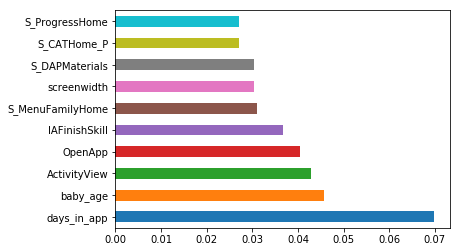

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
#plt.show()
feat_importances


In [23]:
# Prueba Categoricas

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

In [25]:
def load_dataset(dfc):
    data = dfc
    dataset = data.values
    X = dataset[:, :-1]
    y = dataset[:,-1]
# format all fields as string
    X = X.astype(str)
    y = y.astype(str)
    return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X)  # antes X_train
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs


In [29]:
X, y = load_dataset(X2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

Feature 0 device: nan
Feature 1 adjust_network: 0.649424
Feature 2 android_app_version: 32.091657
Feature 3 android_lib_version: 5.040272
Feature 4 timezone: 7.347461
Feature 5 user_relationship: 0.015388
Feature 6 user_role: 0.007598


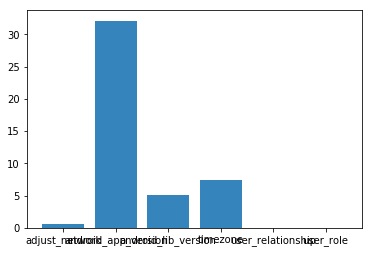

In [30]:
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
x_ps= np.arange(len(X2.columns))
for i in range(len(fs.scores_)):
    #print(catego.columns[i])
    print('Feature %d %s: %f' % (i,X2.columns[i], fs.scores_[i]))
#pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.bar(np.array(X2.columns[0:-1]), fs.scores_, width=0.8, align='center', alpha=0.9)

#fs.scores_
pyplot.show()

In [40]:
fss=list(fs.scores_)
nam= X2.columns[0:-1].tolist()
data = {'Feature':nam,
       'Score':fss}
data=pd.DataFrame(data)
data= data.sort_values(by = 'Score', ascending=False)
data= data.reset_index(drop=True)
data

Feature      Score
0  android_app_version  32.091657
1             timezone   7.347461
2  android_lib_version   5.040272
3       adjust_network   0.649424
4    user_relationship   0.015388
5            user_role   0.007598
6               device        NaN

In [41]:
#catego= data.Feature[0:2].tolist()
catego= data.Feature[3]


In [7]:
h2o.init(min_mem_size = 200)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /root/anaconda3/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp412im9np
  JVM stdout: /tmp/tmp412im9np/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp412im9np/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.1
H2O cluster version age:    1 year, 1 month and 25 days !!!
H2O cluster name:           H2O_from_python_unknownUser_2m1a4s
H2O cluster total nodes:    1
H2O cluster free memory:    200 Gb
H2O cluster total cores:    70
H2O cluster allowed cores:  70
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.5.6 final
--------------------------  ---------------------------------------------------

In [46]:
N= raw_data[feat]
C= raw_data[catego]
Y= raw_data['y']
df= pd.concat( [N, C, Y  ], axis = 1)

In [ ]:
#df= pd.concat( [N, C, Y  ], axis = 1)
#M = pd.concat( [N.reset_index(drop=True), C.reset_index(drop=True), Y.reset_index(drop=True)  ], axis = 1)
#df= pd.concat( [N, Y  ], axis = 1)


In [47]:
X_hf = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [48]:
train, test = X_hf.split_frame(ratios = [.7], seed=0)

In [49]:
 X_hf.describe()

Rows:3352
Cols:27




MenuHelp S_PromoCode days_to_take_FT S_CATHome_F NPSSubmit S_PremiumProcess ClickInDAP S_MenuFamilyProfile MilestonesUpdate DAPActivityCompleted S_MilestonesHome MenuFamilyInvite S_ProgressHome Paywall_Dismiss S_CATViewSkill S_NPSScore OpenApp Feedback_RateActivity S_DAPNewSkills S_Paywall_Soft LogIn MenuMemberStats S_DAPMaterials SkillsViewAllSkills S_MenuFamilyHome adjust_network y 
 
 
 type int int int int int int int int int int int int int int int int int int int int int int int int int enum enum 
 mins 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
 mean 0.13215990453460616 0.013723150357995229 0.04982100238663487 0.08651551312649168 0.02684964200477327 0.6772076372315035 0.013424821002386633 0.5366945107398584 1.1775059665871155 1.1792959427207652 1.1276849642004827 0.15990453460620518 1.540274463007159 0.04266109785202864 0.043854415274463016 0.048031026252983305 5.54982100238662 0.37768496420047676 0.04236276849642007 2.5620525059665917 1.0035799522673048 0.14468973747016708 1.0074582338902152 0.2553699284009546 2.316825775656331 
 maxs 18.0 6.0 3.0 28.0 5.0 102.0 6.0 30.0 64.0 51.0 138.0 15.0 148.0 5.0 45.0 6.0 60.0 36.0 4.0 36.0 6.0 40.0 22.0 24.0 132.0 
 sigma 0.6483118960962118 0.1887374495253578 0.3064412905895114 0.7723416592888335 0.19664716650127032 4.3606696467714094 0.18150526401151335 1.504145924190543 3.234188817191472 2.8328150809272707 4.954322868028403 0.6677753768145089 4.324172407420868 0.2636313354906229 0.8303683572728241 0.3047749925971359 5.141671808483479 1.2654123942025517 0.2343167791499345 1.584870752624423 0.5211025889957465 1.0739343405759907 1.4314969057850193 1.37910866743296 5.313269791543055 
 zeros 3121 3324 3248 3238 3275 3170 3327 2438 2316 2320 2601 2999 1714 3240 3289 3237 0 2910 3230 66 338 3190 1464 3203 1234 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 5.0 0.0 0.0 2.0 1.0 0.0 1.0 0.0 2.0 Instagram Premium 
 1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 3.0 1.0 0.0 0.0 0.0 1.0 Organic Freemium 
 2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 0.0 Organic Premium 
 3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 2.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 1.0 Organic Freemium 
 4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 5.0 8.0 2.0 0.0 6.0 0.0 0.0 0.0 6.0 4.0 0.0 2.0 1.0 1.0 3.0 0.0 6.0 Google Premium 
 5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.0 8.0 0.0 0.0 0.0 0.0 0.0 0.0 8.0 2.0 0.0 2.0 1.0 0.0 0.0 0.0 1.0 Google Freemium 
 6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 1.0 2.0 0.0 1.0 1.0 0.0 0.0 1.0 9.0 0.0 0.0 16.0 1.0 0.0 0.0 0.0 3.0 Organic Premium 
 7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 1.0 0.0 1.0 0.0 0.0 Organic Premium 
 8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 0.0 6.0 0.0 0.0 3.0 0.0 0.0 1.0 0.0 1.0 Restricted Premium 
 9 1.0 0.0 0.0 0.0 0.0 8.0 0.0 0.0 14.0 4.0 7.0 0.0 2.0 0.0 0.0 0.0 11.0 2.0 0.0 0.0 1.0 0.0 1.0 8.0 2.0 Facebook Premium

In [50]:
feat= X_hf.columns[:-1]


In [51]:
#feat= X_hf.columns[:-1]
feat

['MenuHelp',
 'S_PromoCode',
 'days_to_take_FT',
 'S_CATHome_F',
 'NPSSubmit',
 'S_PremiumProcess',
 'ClickInDAP',
 'S_MenuFamilyProfile',
 'MilestonesUpdate',
 'DAPActivityCompleted',
 'S_MilestonesHome',
 'MenuFamilyInvite',
 'S_ProgressHome',
 'Paywall_Dismiss',
 'S_CATViewSkill',
 'S_NPSScore',
 'OpenApp',
 'Feedback_RateActivity',
 'S_DAPNewSkills',
 'S_Paywall_Soft',
 'LogIn',
 'MenuMemberStats',
 'S_DAPMaterials',
 'SkillsViewAllSkills',
 'S_MenuFamilyHome',
 'adjust_network']

In [52]:
nam= ['CeliaBROsFTgbm','CeliaBROsFTDRF','CeliaBROsFTGLM','CeliaBROsFTXGB']
#feat.append('timezone')

#Var= ['language', 'mp_region', 'city', 'signup_provider', 'timezone', 'user_gender',
 #              'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
  #             'baby_age_at_signup_meses', 'edad_bebe_actual_meses']

gbm = H2OGradientBoostingEstimator(model_id = nam[0], seed = 0, balance_classes=True,  nfolds = 10)
gbm.train(  x= feat, y='y', training_frame=train)

DRF = H2ORandomForestEstimator(model_id = nam[1], seed = 0, balance_classes=True, binomial_double_trees=True,  nfolds = 10)
DRF.train(  x= feat, y='y', training_frame=train)

GLM = H2OGeneralizedLinearEstimator(model_id = nam[2], seed = 0,family = 'binomial',  nfolds = 10)
GLM.train(  x= feat, y='y', training_frame=train)

XGB = H2OXGBoostEstimator(model_id = nam[3], seed = 0,  nfolds = 10)
XGB.train(  x= feat, y='y', training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [53]:
m= ['gbm','DRF','GLM','XGB']
nam= ['CeliaBROsFTgbm','CeliaBROsFTDRF','CeliaBROsFTGLM','CeliaBROsFTXGB']

gbmf =  gbm.model_performance(test).confusion_matrix().to_list()
ger= gbmf[1][0]/(gbmf[1][0]+gbmf[1][1])

DRFf =  DRF.model_performance(test).confusion_matrix().to_list()
DRFer= DRFf[1][0]/(DRFf[1][0]+DRFf[1][1])

GLMf =  GLM.model_performance(test).confusion_matrix().to_list()
GLMer= GLMf[1][0]/(GLMf[1][0]+GLMf[1][1])

XGBf =  XGB.model_performance(test).confusion_matrix().to_list()
XGBer= XGBf[1][0]/(XGBf[1][0]+XGBf[1][1])

er= [ger,DRFer,GLMer,XGBer]
data = {'Model':nam,
       'Error':er}

data= pd.DataFrame(data)
data

Error           Model
0  0.104762  CeliaBROsFTgbm
1  0.016667  CeliaBROsFTDRF
2  0.088095  CeliaBROsFTGLM
3  0.176190  CeliaBROsFTXGB

In [56]:
gbm.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.303191202521637: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  -------------
Freemium  155         420        0.7304   (420.0/575.0)
Premium   44          376        0.1048   (44.0/420.0)
Total     199         796        0.4663   (464.0/995.0)

In [57]:
GLM.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3367242575565918: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  -------------
Freemium  133         442        0.7687   (442.0/575.0)
Premium   37          383        0.0881   (37.0/420.0)
Total     170         825        0.4814   (479.0/995.0)

In [55]:
DRF.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15035556139051326: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  -------------
Freemium  51          524        0.9113   (524.0/575.0)
Premium   7           413        0.0167   (7.0/420.0)
Total     58          937        0.5337   (531.0/995.0)

In [54]:
XGB.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3122707009315491: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  -------------
Freemium  214         361        0.6278   (361.0/575.0)
Premium   74          346        0.1762   (74.0/420.0)
Total     288         707        0.4372   (435.0/995.0)

In [ ]:
feat

In [58]:
n1 = list(np.arange(50, 500, 110 ))
n2 =  list(np.arange(20, 242, 120))
params = { 'ntrees': n1, 'max_depth' : n2 }
#XGB = H2OXGBoostEstimator(model_id = "BR", seed = 0,  nfolds = 10)
RF = H2ORandomForestEstimator(model_id = "CeliaBROsXGB", seed = 0, balance_classes=True, binomial_double_trees=True,  nfolds = 10)

#gbm = H2OGradientBoostingEstimator(model_id = "USgbm", seed = 0, balance_classes=True,  nfolds = 10)
grid = H2OGridSearch(model=RF, hyper_params=params)
params 


{'max_depth': [20, 140], 'ntrees': [50, 160, 270, 380, 490]}

In [59]:
grid.train(x=feat, y= 'y', training_frame = train , validation_frame=test)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [65]:
grid.accuracy

    max_depth ntrees  \
0          20    490   
1          20    380   
2          20    270   
3          20    160   
4          20     50   
5         140    490   
6         140    380   
7         140    270   
8         140    160   
9         140     50   

                                                         model_ids  \
0   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_9   
1   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_7   
2   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_5   
3   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_3   
4   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_1   
5  Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_10   
6   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_8   
7   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_6   
8   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_4   
9   Grid_DRF_py_3_sid_a7f2_model_py

<bound method H2OBinomialGridSearch.accuracy of >

In [64]:
grid_train = grid.get_grid(sort_by='recall', decreasing=True )
grid_train 

    max_depth ntrees  \
0         140    380   
1         140    160   
2         140    490   
3         140    270   
4          20    490   
5         140     50   
6          20    380   
7          20    270   
8          20    160   
9          20     50   

                                                         model_ids  \
0   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_8   
1   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_4   
2  Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_10   
3   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_6   
4   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_9   
5   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_2   
6   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_7   
7   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_5   
8   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_3   
9   Grid_DRF_py_3_sid_a7f2_model_py

In [67]:
path='/home/fbfakeevents/Conversion/BehaviorMixpanel/Models/aOS/BR/FT'

g = grid_train
print(g.grid_id)
print(g)
for 0, m in enumerate(g.models):
    print("Save model" + m.model_id + " to " + path + "/" + m.model_id)
    h2o.save_model(model=m, path=path, force=True)

Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814
    max_depth ntrees  \
0         140    380   
1         140    160   
2         140    490   
3         140    270   
4          20    490   
5         140     50   
6          20    380   
7          20    270   
8          20    160   
9          20     50   

                                                         model_ids  \
0   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_8   
1   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_4   
2  Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_10   
3   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_6   
4   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_9   
5   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_2   
6   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_7   
7   Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_5   
8   Grid_DRF_py_3_sid_a7f2_model_python_1599758583

In [5]:

type(enumerate(g.models))


NameError: name 'g' is not defined

In [ ]:
for i, m in enumerate(g.models):
    print(i)
    print(m)
    print(m.model_id)

In [ ]:
#import os
#os.remove("ChangedFile.csv")
#print("File Removed!")
#Para borrar entrenados que no sirven 

In [8]:
## model = grid_train.models[0]
model =  h2o.load_model(path+ '/'+ 'Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_8')
#model

In [9]:
model.model_performance(test)

NameError: name 'test' is not defined

In [10]:
model.accuracy()


[[0.5417039071839366, 0.7269148174659986]]

In [11]:
model.confusion_matrix

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  Grid_DRF_py_3_sid_a7f2_model_python_1599758583169_2814_model_8

Model Summary: 


number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    380                760                         6.28183e+06            27           54           37.125        495           700           642.959



ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.19401861496980116
RMSE: 0.44047544195993626
LogLoss: 0.5818768139239446
Mean Per-Class Error: 0.2732553462406584
AUC: 0.7730222048006641
pr_auc: 0.7624040974091149
Gini: 0.5460444096013282
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3096385739986136: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  --------------
Freemium  627         772        0.5518   (772.0/1399.0)
Premium   185         1210       0.1326   (185.0/1395.0)
Total     812         1982       0.3425   (957.0/2794.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309639     0.716612  275
max f2                       0.0693273    0.836258  377
max f0point5                 0.577634     0.754646  153
max accuracy                 0.541704     0.726915  166
max precision                0.759474     0.887828  75
max recall                   0.00201763   1         399
max specificity              0.985562     0.999285  0
max absolute_mcc             0.567729     0.469767  157
max min_per_class_accuracy   0.43365      0.693907  215
max mean_per_class_accuracy  0.541704     0.726745  166

Gains/Lift Table: Avg response rate: 49.93 %, avg score: 46.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100215                   0.923009           1.1445    1.1445             0.571429         0.945188   0.571429                    0.945188            0.0114695       0.0114695                  14.4496   14.4496
    2        0.0200429                   0.898556           2.00287   1.57368            1                0.90989    0.785714                    0.927539            0.0200717       0.0315412                  100.287   57.3682
    3        0.0300644                   0.879662           1.64521   1.59753            0.821429         0.889052   0.797619                    0.91471             0.0164875       0.0480287                  64.5212   59.7525
    4        0.0400859                   0.862886           1.85981   1.6631             0.928571         0.872124   0.830357                    0.904064            0.018638        0.0666667                  85.9805   66.3095
    5        0.0504653                   0.852259           1.86474   1.70457            0.931034         0.857331   0.851064                    0.894452            0.0193548       0.0860215                  86.4739   70.4568
    6        0.100215                    0.799268           1.75791   1.73105            0.877698         0.825094   0.864286                    0.860021            0.0874552       0.173477                   75.7912   73.105
    7        0.149964                    0.758175           1.87319   1.7782             0.935252         0.778436   0.887828                    0.832956            0.09319         0.266667                   87.3185   77.8202
    8        0.200072                    0.711114           1.63091   1.74131            0.814286         0.733828   0.86941                     0.80813             0.0817204       0.348387                   63.0906   74.1312
    9        0.299928                    0.62783            1.60804   1.69694            0.802867         0.671252   0.847255                    0.762558            0.160573        0.508961                   60.8037   69.694
    10       0.400143                    0.51917            1.13019   1.555              0.564286         0.575814   0.776386                    0.715789            0.113262        0.622222                   13.0189   55.4999
    11       0.5                         0.431006           0.732231  1.39068            0.365591         0.472086   0.694345                    0.667118            0.0731183       0.695341                   -26.7769  39.0681
    12       0.599857                    0.369203           0.710695  1.27749            0.354839         0.39888    0.637828                    0.622465            0.0709677       0.766308                   -28.9305  27.7485
    13       0.700072                    0.316818           0.915597  1.22568            0.457143         0.345826   0.611963                    0.582864            0.0917563       0.858065                   -8.44035  22.5681
    14       0.799928                    0.242376           0.502512  1.13541            0.250896         0.278253   0.56689                     0.544839            0.0501792       0.908244                   -49.7488  13.5406
    15       0.899785                    0.141328           0.56712   1.07234            0.283154         0.19592    0.535402                    0.506116            0.0566308       0.964875                   -43.288   7.23387
    16       1                           0.000890391        0.350502  1                  0.175            0.0813305  0.499284                    0



ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.25598001760282235
RMSE: 0.5059446784015248
LogLoss: 0.728898538576624
Mean Per-Class Error: 0.4324741200828157
AUC: 0.5841387163561076
pr_auc: 0.4911786064774133
Gini: 0.16827743271221518
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08850636401741187: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  -------------
Freemium  52          523        0.9096   (523.0/575.0)
Premium   16          404        0.0381   (16.0/420.0)
Total     68          927        0.5417   (539.0/995.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0885064    0.599852  363
max f2                       0.0124581    0.785928  396
max f0point5                 0.318885     0.507374  237
max accuracy                 0.599345     0.59598   78
max precision                0.864437     0.8       3
max recall                   0.0124581    1         396
max specificity              0.930556     0.998261  0
max absolute_mcc             0.318885     0.136757  237
max min_per_class_accuracy   0.365543     0.561905  206
max mean_per_class_accuracy  0.318885     0.567526  237

Gains/Lift Table: Avg response rate: 42.21 %, avg score: 37.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100503                   0.831357           1.65833   1.65833            0.7              0.866981   0.7                         0.866981            0.0166667       0.0166667                  65.8333    65.8333
    2        0.0201005                   0.780993           0.947619  1.30298            0.4              0.7994     0.55                        0.83319             0.00952381      0.0261905                  -5.2381    30.2976
    3        0.0301508                   0.764944           0.947619  1.18452            0.4              0.776166   0.5                         0.814182            0.00952381      0.0357143                  -5.2381    18.4524
    4        0.040201                    0.731808           0.947619  1.1253             0.4              0.752875   0.475                       0.798856            0.00952381      0.0452381                  -5.2381    12.5298
    5        0.0502513                   0.718398           1.42143   1.18452            0.6              0.725126   0.5                         0.78411             0.0142857       0.0595238                  42.1429    18.4524
    6        0.100503                    0.651709           1.37405   1.27929            0.58             0.68478    0.54                        0.734445            0.0690476       0.128571                   37.4048    27.9286
    7        0.150754                    0.587667           1.37405   1.31087            0.58             0.616302   0.553333                    0.695064            0.0690476       0.197619                   37.4048    31.0873
    8        0.2                         0.548              0.966958  1.22619            0.408163         0.564871   0.517588                    0.663006            0.047619        0.245238                   -3.30418   22.619
    9        0.300503                    0.471182           1.20821   1.22018            0.51             0.51002    0.51505                     0.61184             0.121429        0.366667                   20.8214    22.0178
    10       0.4                         0.41532            0.957191  1.15476            0.40404          0.441344   0.487437                    0.56943             0.0952381       0.461905                   -4.2809    15.4762
    11       0.511558                    0.359948           1.10982   1.14496            0.468468         0.38184    0.483301                    0.528522            0.12381         0.585714                   10.9824    14.4962
    12       0.6                         0.323522           0.996077  1.12302            0.420455         0.345875   0.474037                    0.501599            0.0880952       0.67381                    -0.392316  12.3016
    13       0.699497                    0.260575           0.741823  1.06879            0.313131         0.294076   0.451149                    0.472081            0.0738095       0.747619                   -25.8177   6.87945
    14       0.8                         0.194016           0.97131   1.05655            0.41             0.231212   0.44598                     0.441821            0.097619        0.845238                   -2.86905   5.65476
    15       0.899497                    0.128278           0.861472  1.03497            0.363636         0.161777   0.436872                    0.410844            0.0857143       0.930952                   -13.8528   3.49694
    16       1                           0.000738352        0.687024  1                  0.29             0.0662615  0.422111   



ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.2566944071455157
RMSE: 0.5066501822219308
LogLoss: 0.7412326007392995
Mean Per-Class Error: 0.4275634549581344
AUC: 0.5825343482744161
pr_auc: 0.46110836535818706
Gini: 0.16506869654883216
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06495343644023488: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ---------------
Freemium  89          1310       0.9364   (1310.0/1399.0)
Premium   26          932        0.0271   (26.0/958.0)
Total     115         2242       0.5668   (1336.0/2357.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0649534    0.5825    373
max f2                       0.00376873   0.773954  399
max f0point5                 0.318036     0.496643  246
max accuracy                 0.552751     0.600764  119
max precision                0.552751     0.519016  119
max recall                   0.00376873   1         399
max specificity              0.994201     0.999285  0
max absolute_mcc             0.318036     0.144873  246
max min_per_class_accuracy   0.367648     0.555397  216
max mean_per_class_accuracy  0.318036     0.572437  246

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 37.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101824                   0.901415           1.02514   1.02514            0.416667         0.951599   0.416667                    0.951599            0.0104384       0.0104384                  2.51392   2.51392
    2        0.0203649                   0.841726           1.02514   1.02514            0.416667         0.868078   0.416667                    0.909839            0.0104384       0.0208768                  2.51392   2.51392
    3        0.030123                    0.780059           0.962739  1.00493            0.391304         0.807249   0.408451                    0.876605            0.00939457      0.0302714                  -3.72606  0.492517
    4        0.0403055                   0.747083           1.02514   1.01003            0.416667         0.759646   0.410526                    0.847058            0.0104384       0.0407098                  2.51392   1.00319
    5        0.0500636                   0.727714           1.60457   1.12592            0.652174         0.736976   0.457627                    0.825601            0.0156576       0.0563674                  60.4566   12.5916
    6        0.100127                    0.643033           1.25102   1.18847            0.508475         0.682644   0.483051                    0.754123            0.0626305       0.118998                   25.1017   18.8466
    7        0.151039                    0.583677           1.31218   1.23017            0.533333         0.6125     0.5                         0.706385            0.0668058       0.185804                   31.2178   23.0167
    8        0.200255                    0.542984           1.27259   1.24059            0.517241         0.562866   0.504237                    0.671113            0.0626305       0.248434                   27.2587   24.0592
    9        0.299958                    0.466753           1.16212   1.21451            0.47234          0.505004   0.493635                    0.6159              0.115866        0.364301                   16.2115   21.4507
    10       0.400085                    0.409219           1.05294   1.17407            0.427966         0.436416   0.4772                      0.570981            0.105428        0.469729                   5.29396   17.4072
    11       0.500636                    0.362117           1.00697   1.14051            0.409283         0.38421    0.463559                    0.533469            0.101253        0.570981                   0.697216  14.0511
    12       0.599915                    0.314964           1.14605   1.14143            0.465812         0.340688   0.463932                    0.501566            0.113779        0.68476                    14.6053   14.1428
    13       0.700042                    0.259353           0.771461  1.08851            0.313559         0.287523   0.442424                    0.470951            0.0772443       0.762004                   -22.8539  8.85114
    14       0.799745                    0.197682           0.889908  1.06375            0.361702         0.228343   0.432361                    0.440706            0.0887265       0.850731                   -11.0092  6.37518
    15       0.899873                    0.116767           0.719335  1.02543            0.292373         0.156543   0.416785                    0.409088            0.0720251       0.922756                   -28.0665  2.54292
    16       1                           0.00376873         0.771461  1                  0.313559         0.0626697  0.406449                  


Cross-Validation Metrics Summary: 


mean        sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  ----------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.509732    0.0575201   0.506329      0.5           0.573222      0.375         0.46888       0.581301      0.390244      0.632035      0.592437      0.477876
auc                      0.582254    0.0231602   0.58477       0.575812      0.613564      0.546189      0.570419      0.596964      0.545339      0.653435      0.592605      0.543447
err                      0.490268    0.0575201   0.493671      0.5           0.426778      0.625         0.53112       0.418699      0.609756      0.367965      0.407563      0.522124
err_count                115         11.9248     117           135           102           140           128           103           125           85            97            118
f0point5                 0.501095    0.0361282   0.468354      0.501433      0.524193      0.410526      0.512452      0.562579      0.428241      0.584416      0.509404      0.509355
f1                       0.592588    0.0263526   0.558491      0.608696      0.604651      0.527027      0.625731      0.633452      0.542125      0.628821      0.572687      0.624204
f2                       0.732302    0.034016    0.691589      0.774336      0.714286      0.735849      0.803303      0.724756      0.738523      0.680529      0.653923      0.805921
lift_top_group           0.929155    0.402657    1.75556       0.810811      0             0             1.48765       1.47748       0.899123      0.77          1.32222       0.768707
logloss                  0.74177     0.0152779   0.716641      0.722563      0.729335      0.745154      0.771663      0.744285      0.750566      0.727623      0.723487      0.786381
max_per_class_error      0.739656    0.137976    0.687075      0.811321      0.587413      0.958904      0.954887      0.6           0.953488      0.435115      0.486486      0.921875
mcc                      0.177918    0.0474031   0.149236      0.194862      0.23613       0.12126       0.106173      0.217331      0.0503716     0.284257      0.23129       0.18827
mean_per_class_accuracy  0.569628    0.0316373   0.567574      0.567313      0.612544      0.520548      0.517927      0.600901      0.510098      0.642443      0.617868      0.539062
mean_per_class_error     0.430372    0.0316373   0.432426      0.432687      0.387456      0.479452      0.482073      0.399099      0.489902      0.357557      0.382132      0.460938
mse                      0.25668     0.00730485  0.246796      0.259408      0.250812      0.257908      0.270386      0.259952      0.25574       0.24166       0.247186      0.276952
precision                0.455358    0.040767    0.422857      0.448718      0.481482      0.357798      0.457265      0.523529      0.375635      0.55814       0.474453      0.453704
r2                       -0.0701803  0.0302062   -0.0477897    -0.0714955    -0.0436058    -0.136353     -0.0933088    -0.0497992    -0.096234     0.0156318     -0.0511705    -0.127678
recall                   0.878912    0.0770326   0.822222      0.945946      0.8125        1             0.990741      0.801802      0.973684      0.72          0.722222      1
rmse                     0.506534    0.0071765   0.496785      0.509321      0.500811      0.507846      0.519987      0.509855      0.505707      0.491589      0.497178      0.526262
specificity              0.260344    0.137976    0.312925      0.188679      0.412587      0.0410959     0.0451128     0.4           0.0465116     0.564886      0.513513      0.078125

Scoring History: 


timestamp            duration          number_of_trees    training_rmse        training_logloss    training_auc        training_pr_auc      training_lift       training_classification_error    validation_rmse     validation_logloss    validation_auc      validation_pr_auc    validation_lift     validation_classification_error
---  -------------------  ----------------  -----------------  -------------------  ------------------  ------------------  -------------------  ------------------  -------------------------------  ------------------  --------------------  ------------------  -------------------  ------------------  ---------------------------------
     2020-09-10 17:39:19  2 min 54.430 sec  0.0                nan                  nan                 nan                 nan                  nan                 nan                              nan                 nan                   nan                 nan                  nan                 nan
     2020-09-10 17:39:19  2 min 54.471 sec  1.0                0.5998083157413855   10.231370047989781  0.6650538241493527  0.3181519524515223   1.4376746698090048  0.47674418604651164              0.678746403926682   13.631526610588994    0.543265010351967   0.3281786779287513   1.149240121580547   0.5778894472361809
     2020-09-10 17:39:20  2 min 54.501 sec  2.0                0.5811980802008946   8.97755776906704    0.6722305389221557  0.32763255176829775  1.4265026688326758  0.4937906564163217               0.587644448766965   7.376061778636055     0.5570434782608696  0.3617572875930449   1.2183673469387755  0.5778894472361809
     2020-09-10 17:39:20  2 min 54.533 sec  3.0                0.5640026935166461   7.787020118833316   0.6809291451105243  0.3519605767637494   1.4152753751003473  0.38326200665715643              0.547669735475657   4.540667336632899     0.5768985507246376  0.4150089563989582   1.250330687830688   0.5778894472361809
     2020-09-10 17:39:20  2 min 54.573 sec  4.0                0.5507490982510352   6.827811143125919   0.6845953650218819  0.37006138148023565  1.411659541391372   0.39200680272108845              0.5249732937885592  2.8793399429366597    0.5962443064182195  0.45400766995142616  1.328102453102453   0.5195979899497487
---  ---                  ---               ---                ---                  ---                 ---                 ---                  ---                 ---                              ---                 ---                   ---                 ---                  ---                 ---
     2020-09-10 17:39:23  2 min 58.291 sec  54.0               0.44525976860713185  0.7252625591192478  0.7661424827257565  0.7339060463358165   1.5736815156169994  0.3264137437365784               0.5074368630383598  0.7356842777852447    0.5845403726708074  0.48640937837846626  1.4214285714285715  0.5296482412060302
     2020-09-10 17:39:23  2 min 58.396 sec  55.0               0.4449230537106617   0.713118309135367   0.7667232867306653  0.7356835731195804   1.612063991607658   0.3264137437365784               0.5072260543908345  0.7348309682694862    0.5846293995859213  0.4867237400248839   1.4214285714285715  0.5457286432160804
     2020-09-10 17:39:27  3 min  2.402 sec  202.0              0.4416666095447228   0.5851980736406966  0.7710387091650205  0.7609113521104388   1.4306195596518176  0.33786685755189694              0.5060257655135642  0.730440622012614     0.5851739130434783  0.492907882358574    1.4214285714285715  0.5467336683417086
     2020-09-10 17:39:31  3 min  6.403 sec  328.0              0.44054150603099246  0.582531150235766   0.7729192126480512  0.7631657452497088   1.3590885816692269  0.34609878310665715              0.5063648960014205  0.73021035899745      0.5839730848861284  0.490335705156639    1.4214285714285715  0.5467336683417086
     2020-09-10 17:39:33  3 min  8.373 sec  380.0              0.44047544195993626  0.5818768139239446  0.7730222048006641  0.7624040974091149   1.144495647721454   0.


See the whole table with table.as_data_frame()
Variable Importances: 


variable          relative_importance    scaled_importance     percentage
----------------  ---------------------  --------------------  ---------------------
OpenApp           34756.29296875         1.0                   0.12736643952232735
adjust_network    32116.546875           0.9240498376474314    0.11769293776233797
S_MenuFamilyHome  25774.0390625          0.7415646739332614    0.09445045219441513
S_DAPMaterials    23320.15234375         0.6709620144103849    0.08545804283017921
S_ProgressHome    22910.966796875        0.6591890227612783    0.08395855880130641
---               ---                    ---                   ---
Paywall_Dismiss   1877.146240234375      0.05400881624292184   0.006878910627676594
S_CATHome_F       1414.047607421875      0.04068464978970198   0.005181858986927144
NPSSubmit         967.0550537109375      0.027823883708784303  0.0035438290016711446
S_PromoCode       359.47161865234375     0.010342634036821794  0.0013173044725524274
ClickInDAP        319.459228515625       0.009191406828192422  0.0011706767619080766


See the whole table with table.as_data_frame()


<bound method H2OBinomialModel.confusion_matrix of >

In [12]:
model.varimp_plot(num_of_features=55)

<Figure size 1400x1000 with 1 Axes>

In [13]:
roc = model.model_performance(test_data=test, train=train)

NameError: name 'test' is not defined

In [ ]:
roc.plot()